In [ ]:
library(Seurat)
library(ggplot2)
library(tidyr)
library(dplyr)
library(Hmisc)

### 1. load data

In [ ]:
library(Seurat)
library(ggplot2)
library(tidyr)
library(dplyr)
library(Hmisc)

objs <- readRDS(".//ST_seuratobj_merge.rds")
head(objs@meta.data)

meta <- readRDS("./Visium/0_processing/outputdata/region.metadata.rds")

objs$barcode <- colnames(objs)
table(objs$orig.ident, sapply(objs$barcode, function(x){unlist(strsplit(x, split = "_"))[2]}))

spots <- c()
samples <- c("A1", "B1")
for(index in 1:2){ 
    spot <- read.csv(paste0("./Visium/0_processing/selected_spots/",samples[index], "_selected_spots4.csv"))$Barcode
    spot <- paste0(spot, "_", index)
    spots <- append(spots, spot)
    print(paste(samples[index], length(spot)))
}
length(spots)

obj <- subset(objs, cells = unique(c(spots, rownames(meta))))
table(obj$orig.ident)

obj$group <- ifelse(obj$orig.ident %in% c("A1", "B1"), "Control", "Vcl cKO")

### 2. annotate the regions

#### CARD deconvolution

In [175]:
##### merge cell subtypes 
library(data.table)
library(Matrix)
library(CARD)
library(SingleCellExperiment) 
library(MuSiC) 
library(scatterpie)

meta <- read.delim("/Public/scRNA/GSE186525_sc_meta.txt.gz")
table(meta$time, meta$sample)
meta <- subset(meta, time == "E13.5")

mat.count <- readRDS("/Public/scRNA/GSE186525_sc_UMIcounts.rds")

meta$subtype <- meta$celltype
meta$celltype <- plyr::mapvalues(x = meta$subtype,
                                  from = c("Gastric epithelium 1", "Gastric epithelium 2", 
                                           "Large intestinal fibroblasts", "Large intestinal myofibroblasts/myocytes",
                                           "Large intestinal epithelium 1", "Large intestinal epithelium 2", 
                                           "Small intestinal epithelium 1", "Small intestinal epithelium 2", 
                                           "Small intestinal fibroblasts 1", "Small intestinal fibroblasts 2", "Small intestinal myofibroblasts/myocytes"), 
                                  to = c("Gastric epithelium", "Gastric epithelium", 
                                         "Large intestinal fibroblasts", "Large intestinal myofibroblasts/myocytes", 
                                         "Large intestinal epithelium", "Large intestinal epithelium", 
                                         "Small intestinal epithelium", "Small intestinal epithelium", 
                                         "Small intestinal fibroblasts", "Small intestinal fibroblasts", "Small intestinal myofibroblasts/myocytes"))


unique(sort(meta$celltype))
meta <- meta[!meta$celltype %in% c("Blood cells", "Secretory progenitors", 
                                    "Telocytes", "Other mesenchymal cells of E9.5", 
                                    "T cells", "Macrophages", "Other intestinal fibroblasts", 'Mesothelial cells', "Neural crest cells",
                                   'Endothelial cells', 'Liver epithelium', 'Endothelial cells' # remove in later version
                                  ),]


In [116]:

var.deconvolu <- "celltype"
obj@meta.data <- obj@meta.data
################## deconvolution for each sample
results.card <- data.frame()
samples <- c("A1", "B1", "C1", "D1")
for(sample in samples){ 
    spot.temp <- obj@meta.data %>% filter(orig.ident == sample) %>% pull(barcode)
    spatialcount <- obj@assays$Spatial@counts[,spot.temp]
    spatialInfo <- data.frame(x = obj@images[[sample]]@coordinates$row, 
                              y = -obj@images[[sample]]@coordinates$col, 
                              row.names = rownames(obj@images[[sample]]@coordinates))[spot.temp,]

    CARD_obj = createCARDObject(
      sc_count = mat.count[, meta$cells],
      sc_meta = meta,
      spatial_count = spatialcount,
      spatial_location = spatialInfo,
      ct.varname = var.deconvolu,
      ct.select = unique(meta[,var.deconvolu]),
      sample.varname = NULL,
      minCountGene = 100,
      minCountSpot = 1) 
    CARD_obj = CARD_deconvolution(CARD_object = CARD_obj)

    #### save result
    proportion <- CARD_obj@Proportion_CARD
    spatial_location <- CARD_obj@spatial_location
    results.card <- rbind(results.card, cbind(spatial_location, proportion))
}


dim(obj@meta.data)
dim(results.card)
obj@meta.data <- cbind(obj@meta.data, results.card[,3:ncol(results.card)])

## QC on scRNASeq dataset! ...
## QC on spatially-resolved dataset! ...
## create reference matrix from scRNASeq...


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


## Select Informative Genes! ...
## Deconvolution Starts! ...
## Deconvolution Finish! ...
## QC on scRNASeq dataset! ...
## QC on spatially-resolved dataset! ...
## create reference matrix from scRNASeq...


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


## Select Informative Genes! ...
## Deconvolution Starts! ...
## Deconvolution Finish! ...
## QC on scRNASeq dataset! ...
## QC on spatially-resolved dataset! ...
## create reference matrix from scRNASeq...


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


## Select Informative Genes! ...
## Deconvolution Starts! ...
## Deconvolution Finish! ...
## QC on scRNASeq dataset! ...
## QC on spatially-resolved dataset! ...
## create reference matrix from scRNASeq...


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


## Select Informative Genes! ...
## Deconvolution Starts! ...
## Deconvolution Finish! ...


[1] 11825     8

[1] 11825    11

#### spot annotation

In [5]:
regions <- c("LI", "SI", "ST")
obj$LI <- rowSums(obj@meta.data[, grep(colnames(obj@meta.data), pattern = "Large", ignore.case = T, value = T)])
obj$SI <- rowSums(obj@meta.data[, grep(colnames(obj@meta.data), pattern = "Small", ignore.case = T, value = T)])
obj$ST <- rowSums(obj@meta.data[, grep(colnames(obj@meta.data), pattern = "Gastric", ignore.case = T, value = T)])

############ regions first round

obj$region_1 <- regions[apply(obj@meta.data[,regions], MARGIN = 1, which.max)]
options(repr.plot.width = 15, repr.plot.height = 6)
SpatialDimPlot(obj, 
               group.by = "region_1", 
               pt.size.factor = 1500, 
               crop = F) & theme(legend.position = 'right')

SpatialDimPlot(obj, 
               group.by = "region_1", 
               pt.size.factor = 1500, 
               crop = F) & theme(legend.position = 'right') & NoLegend()


############ calculate the stomach score
obj <- AddModuleScore(obj, features = list(gene = c("Barx1","Sox2","Gata4","Igf1","Nkx2-5" )), name = "ST_Score",nbin = 10)
obj <- AddModuleScore(obj, features = list(gene = c("Tff3","Tdo2","Lum","Gpr50","Agr2","Sulf1")), name = "SI_Score",nbin = 10)
obj <- AddModuleScore(obj, features = list(gene = c("Fxyd4","Muc2","Ntm","Fabp1","Cdx2","Satb2")), name = "LI_Score",nbin = 10)

options(repr.plot.width = 6, repr.plot.height = 4)
VlnPlot(subset(obj, orig.ident %in% c("A1", "D1")), features = c("ST_Score1", "SI_Score1", "LI_Score1"), group.by = "region", split.by = "region", stack = T, flip = T,alpha = 0.2, cols = c("LI" = "#fa58d0", "SI" = "#3ADF00", "ST" = "#6666FF")) & scale_color_manual(values = c("LI" = "#fa58d0", "SI" = "#3ADF00", "ST" = "#6666FF")) 

region_score <- c("ST_Score1")
pdf("temp.region.score.pdf", width = 15, height = 6)
DefaultAssay(obj) <- "SCT"
for(feature in regions){ 
    p <- SpatialFeaturePlot(obj, features = feature, image.alpha =  1, pt.size.factor = 1500, crop = F)
    print(p)
}
for(feature in region_score){ 
    p <- SpatialFeaturePlot(obj, features = feature, image.alpha =  1, pt.size.factor = 1500, crop = F)
    print(p)
}
dev.off()

############ regions second round

obj$region <- "SI"
obj$region[regions[apply(obj@meta.data[,regions], MARGIN = 1, which.max)] == "ST" & obj$ST_Score1 > 0.3] <- "ST"
obj$region[regions[apply(obj@meta.data[,regions], MARGIN = 1, which.max)] == "LI"] <- "LI"

SpatialDimPlot(obj, 
               group.by = "region", 
               pt.size.factor = 1500, 
               crop = F) & theme(legend.position = 'right')


### 3 annotate cell types

In [90]:
###### scRNA
library(data.table)
library(Matrix)
library(CARD)
library(SingleCellExperiment) 
library(MuSiC) 
library(scatterpie)

meta <- read.delim("./scRNA/GSE186525_sc_meta.txt.gz")
table(meta$time, meta$sample)
meta <- subset(meta, time == "E13.5")

mat.count <- readRDS("//scRNA/GSE186525_sc_UMIcounts.rds")

##### merge cell subtypes 
table(meta$type,meta$celltype)

meta$subtype <- meta$celltype
sort(unique(meta$subtype))
meta$celltype <- plyr::mapvalues(x = meta$subtype,
                                  from = c("Gastric epithelium 1", "Gastric epithelium 2", 
                                           "Large intestinal fibroblasts", "Large intestinal myofibroblasts/myocytes",
                                           "Large intestinal epithelium 1", "Large intestinal epithelium 2", 
                                           "Small intestinal epithelium 1", "Small intestinal epithelium 2", 
                                           "Small intestinal fibroblasts 1", "Small intestinal fibroblasts 2", "Small intestinal myofibroblasts/myocytes"), 
                                  to = c("Gastric epithelium", "Gastric epithelium", 
                                         "Large intestinal fibroblasts", "Large intestinal myofibroblasts/myocytes", 
                                         "Large intestinal epithelium", "Large intestinal epithelium", 
                                         "Small intestinal epithelium", "Small intestinal epithelium", 
                                         "Small intestinal fibroblasts", "Small intestinal fibroblasts", "Small intestinal myofibroblasts/myocytes"))

table(meta$celltype)
meta <- meta[!meta$celltype %in% c("Blood cells", "Secretory progenitors", 
                                    "Telocytes", "Other mesenchymal cells of E9.5", 
                                    "T cells", "Macrophages", 
                                   'Endothelial cells', 'Liver epithelium', 'Endothelial cells' # remove in later version
                                  ),]
sort(unique(meta$celltype))
table(meta$time)

##### keep EPI, MES, Neural crest cells.

meta$type[meta$celltype == "Neural crest cells"] <- "Neural crest cells"
meta <- meta[-which(meta$type == "OTHERS"),]

table(meta$celltype,meta$type) %>% as.data.frame() %>% filter(Freq > 0)
table(meta$type) 

# cells.sub <- c(sample(meta$cells[meta$type == "MES"], min(table(meta$type))), 
#           sample(meta$cells[meta$type == "EPI"], min(table(meta$type))), 
#           sample(meta$cells[meta$type == "Neural crest cells"], min(table(meta$type))))

# meta <- subset(meta, cells %in% cells.sub)

In [92]:
# obj <- readRDS("./outputdata/annotated.obj.rds")
var.deconvolu <- "type"

################## deconvolution for each sample
results.card <- data.frame()
samples <- c("A1", "B1", "C1", "D1")
for(sample in samples){ 
    spot.temp <- obj@meta.data %>% filter(orig.ident == sample) %>% pull(barcode)
    spatialcount <- obj@assays$Spatial@counts[,spot.temp]
    spatialInfo <- data.frame(x = obj@images[[sample]]@coordinates$row, 
                              y = -obj@images[[sample]]@coordinates$col, 
                              row.names = rownames(obj@images[[sample]]@coordinates))[spot.temp,]

    CARD_obj = createCARDObject(
      sc_count = mat.count[, meta$cells],
      sc_meta = meta,
      spatial_count = spatialcount,
      spatial_location = spatialInfo,
      ct.varname = var.deconvolu,
      ct.select = unique(meta[,var.deconvolu]),
      sample.varname = NULL,
      minCountGene = 100,
      minCountSpot = 1) 
    CARD_obj = CARD_deconvolution(CARD_object = CARD_obj)

    #### save result
    proportion <- CARD_obj@Proportion_CARD
    spatial_location <- CARD_obj@spatial_location
    results.card <- rbind(results.card, cbind(spatial_location, proportion))

}
saveRDS(results.card, file = "./outputdata/results.card.type.rds")

obj@meta.data <- cbind(obj@meta.data, results.card[colnames(obj),])

#### annotate neural crest cells

In [2]:
i <- 1
j <- 0.4
k <- 0.4

cutoffs <- list("YFP" = i, "Phox2b" = j, "Sox10" = k)

temp.obj <- subset(obj, orig.ident %in% c("A1", "D1"))
table(temp.obj$orig.ident)

options(repr.plot.width = 5, repr.plot.height = 4)
for(gene in c("YFP")){
    exp.mat <- data.frame("exp" = temp.obj@assays$SCT$data[gene,])
    p <- ggplot(exp.mat, aes(x = exp)) + 
        geom_density(fill = colors["NC"], alpha = 0.5) + 
        geom_vline(xintercept = cutoffs[[gene]], col = "red", show.legend = T) + 
        theme_bw() + 
        theme(axis.text = element_text(size = 14), axis.title = element_text(size = 16)) +
        annotate("text", x = cutoffs[[gene]], y = Inf, label = paste0("cutoff: ",cutoffs[[gene]]), vjust = 1.5, hjust = -0.1, size = 5, color = "red") + 
        xlab("YFP expression") + ggtitle(paste0(gene, " expression"))  + scale_x_continuous(breaks = seq(-2, max(exp.mat$exp) + 1, by = 1)) & ylab(NULL)
    print(p)
}


In [1]:


cutoffs <- list("EPI" = 0.3)

options(repr.plot.width = 5, repr.plot.height = 4)
for(gene in c("EPI")){
    exp.mat <- data.frame("exp" = temp.obj@meta.data[,gene])
    p <- ggplot(exp.mat, aes(x = exp)) + 
        geom_density(fill = colors["EPI"], alpha = 0.5) + 
        geom_vline(xintercept = cutoffs[[gene]], col = "red", show.legend = T) + 
        theme_bw() + 
        theme(axis.text = element_text(size = 14), axis.title = element_text(size = 16)) +
        annotate("text", x = cutoffs[[gene]], y = Inf, label = paste0("cutoff: ",cutoffs[[gene]]), vjust = 1.5, hjust = -0.1, size = 5, color = "red") + 
        xlab("EPI proportion in spots") + ggtitle(paste0(gene, " score"))  + scale_x_continuous(breaks = seq(-2, max(exp.mat$exp) + 1, by = 1)) & ylab(NULL)
    print(p)
}


In [3]:
# obj <- readRDS("./obj.final.rds")

library(ggplot2)
library(magrittr)
# i;j;k
i = 1

types <- c("MES", "Neural crest cells", "EPI")
obj$anno2 <- types[apply(obj@meta.data[,types], MARGIN = 1, which.max)]
obj@meta.data[which(obj@meta.data[,"EPI"] > 0.3), "anno2"] <- "EPI"

obj@meta.data[obj@assays$SCT$data["YFP",] > i, "anno2"] <- "Neural crest cells"

table(obj$orig.ident, obj$anno2)

table(obj$anno2) %>% prop.table() 
table(obj$region, obj$anno2, obj$group)

In [178]:
options(repr.plot.width = 15, repr.plot.height = 6)
pdf("./spatial.region.annotation.pdf", width = 10, height = 5)

SpatialDimPlot(obj, 
               group.by = "anno2", 
               pt.size.factor = 1800, 
               cols = c("MES" = "#FFE4B5", 
                        "NC" = "#E41A1C", 
                        "EPI" = "#4DAF4A"),
               crop = F) & theme(legend.position = 'right') & NoLegend()
dev.off()

png 
  2

In [65]:
options(repr.plot.width = 8, repr.plot.height = 15)


obj@meta.data[obj$anno2 == "Neural crest cells", "anno2"] = "NC"
DefaultAssay(obj) <- "SCT"
genes <- c("YFP", "Sox10", "Phox2b", "Epcam", "Cdx2", "Lum")
colors <- c("A1" = "#2A7BDE", "B1" = "#5DBB63", "C1" = "#F05D5E", "D1" ="#A3BFFA", 
          "Control" = "#04a29d", "Vcl cKO" = "#b2012e", 
           "MES" = "#FFE4B5", "NC" = "#4DAF4A", "EPI" = "#E41A1C" )

pdf("figures.pdf", height = 6, width = 6)
for(split in c("anno2")){ 
    # width <- length(unique(obj@meta.data[,split])) * 2
    options(repr.plot.width = 6, repr.plot.height = 6)
    
    p <- VlnPlot(temp.obj, features = genes, layer = "data", ,
    group.by = "anno2", pt.size = 1, flip = T, stack = T,
    cols = c("MES" = "#FFE4B5", "NC" = "#4DAF4A", "EPI" = "#E41A1C"),
    split.by = split) & scale_fill_manual(values = c("MES" = "#FFE4B5", "NC" = "#4DAF4A", "EPI" = "#E41A1C")) &
    theme(axis.text.x = element_text(size = 16), 
          axis.text.y = element_text(size = 16), 
          axis.title = element_text(size = 18)) & scale_y_continuous(breaks = seq(0, 6, by = 3)) & xlab(NULL)
    print(p)
}
dev.off()

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

### 4.region of interest

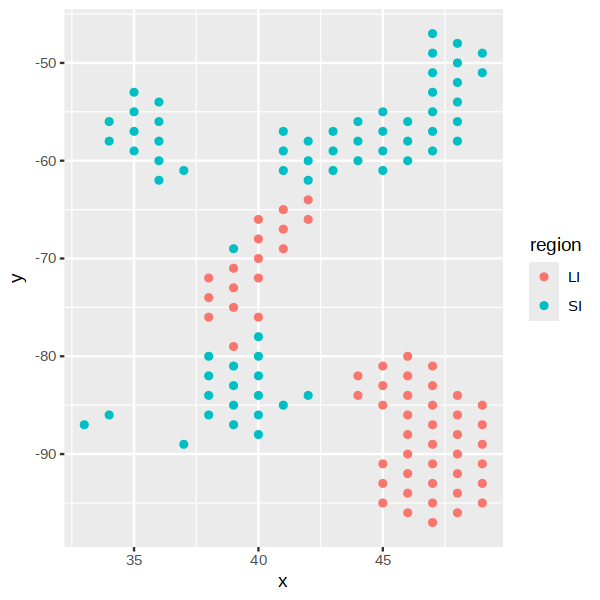

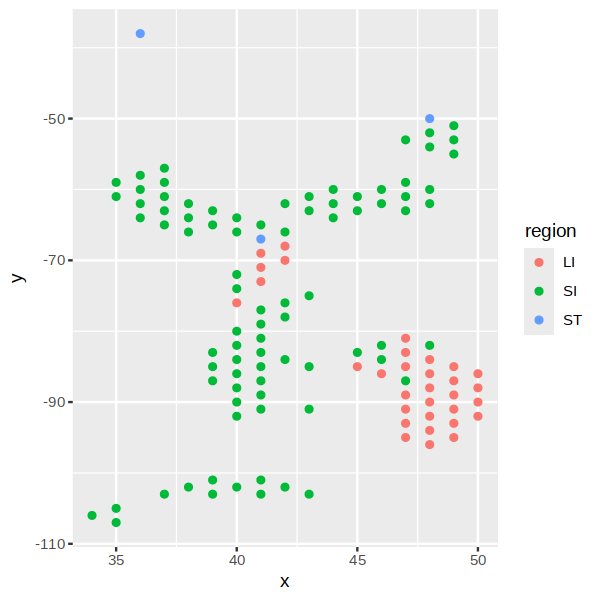

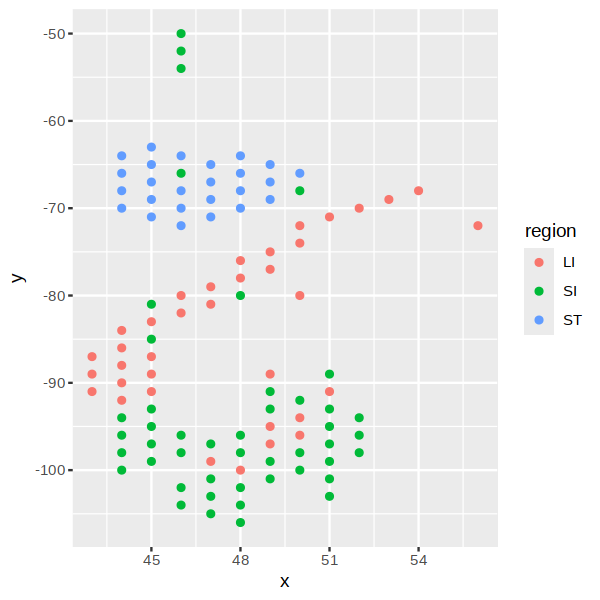

In [3]:

library(dplyr)
library(ggplot2)
library(Seurat)
spatial_cors <- data.frame("x" = obj@meta.data$x, 
                           "y" = obj@meta.data$y, 
                          "section" = obj$orig.ident, 
                           "region" = obj$region,
                           "anno2" = obj@meta.data$anno2)

options(repr.plot.width = 5, repr.plot.height = 5)

ggplot(subset(spatial_cors, section == "A1"), aes(x = x, y = y, color = region)) + geom_point()
ggplot(subset(spatial_cors, section == "B1"), aes(x = x, y = y, color = region)) + geom_point()
ggplot(subset(spatial_cors, section == "D1"), aes(x = x, y = y, color = region)) + geom_point()


In [153]:
cells <- c(
    # subset(spatial_cors, section == "A1" & region == "LI" & x < 42.5) %>% rownames(), 
    subset(spatial_cors, section == "A1" & region == "LI" & x < 42.5) %>% rownames(), 
    
    subset(spatial_cors, section == "B1" & region == "LI" & x > 42.5) %>% rownames(), 
    subset(spatial_cors, section == "B1" & region == "SI" & x > 43 & y < -80) %>% rownames(),
    subset(spatial_cors, section == "D1" & region %in% c("LI", "SI") & y < (1.1111*x-125) & y > -95) %>% rownames()
          )
cell.rm <- subset(spatial_cors, section == "D1" & region %in% c("LI", "SI") & x > 48 & y < -85 | x > 54.5) %>% rownames()
cells <- cells[-which(cells %in% cell.rm)]

i = "D1"
spatial_cors$state <- ifelse(rownames(spatial_cors) %in% cells, "included", "excluded")
for(i in unique(spatial_cors[cells,]$section)){ 
    p <- ggplot(subset(spatial_cors, section == i), aes(x = x, y = y, color = state)) + geom_point()
    # print(p)
}

cells.final <- obj$barcode[which(obj$barcode %in% rownames(spatial_cors[spatial_cors$state == "included",]))]


In [72]:
obj@meta.data[obj$anno2 == "Neural crest cells", "anno2"] <- "NC"
p <- SpatialDimPlot(
    obj[,cells.final], 
    temp.obj,
               group.by = "anno2", 
               pt.size.factor = 1700, 
               cols = c("MES" = "#FFE4B5", 
                        "EPI" = "#E41A1C", 
                        "NC" = "#4DAF4A"),
               crop = F) & theme(legend.position = 'right') & NoLegend()

pdf("./spatial.anno.final.proportion.pdf", width = 10, height = 5)
print(p) 
dev.off()

Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”


pdf 
  2

In [3]:
table(obj$anno2, obj$orig.ident)
library(Seurat)

cells.final <- c(cells.final, subset(obj@meta.data, anno2 == "EPI" & orig.ident == "A1") %>% rownames())
cells.final <- c(cells.final, subset(obj@meta.data, anno2 == "EPI" & orig.ident == "B1") %>% rownames())
cells.final <- c(cells.final, subset(obj@meta.data, anno2 == "EPI" & orig.ident == "D1") %>% rownames())
cells.final <- c(cells.final, subset(obj@meta.data, region == "LI" & orig.ident == "A1") %>% rownames()) %>% unique()

obj.final <- obj[,cells.final]
table(obj.final$anno2, obj.final$orig.ident)
table(subset(obj.final@meta.data, orig.ident == "A1")[, "anno2"]) %>% prop.table()
table(subset(obj.final@meta.data, orig.ident == "D1")[, "anno2"]) %>% prop.table()


In [ ]:
saveRDS(obj, file = "obj.target.region.rds")  
obj.final <- readRDS("./obj.final.rds")


### 5.cellchat

In [4]:
library(Seurat)
library(ggplot2)
library(CellChat)
library(tidyr)
library(dplyr)
library(Hmisc)
set.seed(2025)
setwd("./Visium/processing2/")

CellChatDB <- CellChatDB.mouse 
CellChatDB.use <- CellChatDB

interaction.levels <- "anno2"
cellchats <- list()
sections <- c("A1",  "D1")
for(g in sections){
    cells <- obj.temp@meta.data %>% filter(orig.ident == g ) %>% rownames())
    obj_con <- obj.temp[,cells]
    table(obj_con$anno2)
    obj_con@meta.data[,interaction.levels] <- as.character(obj_con@meta.data[,interaction.levels])
    cc_con <- createCellChat(object = normalizeData(GetAssayData(obj_con, layer = "counts", assay = "Spatial")), meta = obj_con@meta.data, group.by = interaction.levels)
    
    cc_con <- setIdent(cc_con, ident.use = interaction.levels)
    cc_con@DB <- CellChatDB.use
    cc_con <- CellChat::subsetData(cc_con) 
    cc_con <- updateCellChat(cc_con)
    cc_con <- identifyOverExpressedGenes(cc_con)
    cc_con <- identifyOverExpressedInteractions(cc_con)
    cc_con <- computeCommunProb(cc_con, population.size = T) 
    cc_con <- filterCommunication(cc_con, min.cells = 1)
    cc_con <- computeCommunProbPathway(cc_con)
    cc_con <- aggregateNet(cc_con)
    cc_con <- netAnalysis_computeCentrality(cc_con, slot.name = "netP") 
    # cellchats[[paste0(r, "_", g)]] <- cc_con
    cellchats[[g]] <- cc_con

}


In [3]:
########## count

for(i in 1:2){ 
    cellchat@net[[i]]$count["MES","MES"] <- 0
    cellchat@net[[i]]$count["EPI",] <- 0
    cellchat@net[[i]]$count[,"EPI"] <- 0
    

    cellchat@net[[i]]$weight["MES","MES"] <- 0
    cellchat@net[[i]]$weight[,"EPI"] <- 0
    cellchat@net[[i]]$weight["EPI",] <- 0
    
}

#### compare number and weight

In [5]:
library(ggplot2)

p1 <- ggplot(data.num, aes(x = Freq, y = Var1, fill = Var2)) + 
  geom_bar(stat = "identity", width = 0.8, position = "dodge") +
  scale_fill_manual(values = c("Vcl cKO"="#f82401", "Control" = "#0f7dbd")) +
  scale_x_continuous(
    breaks = c(min(data.num$Freq), max(data.num$Freq)),  
    labels = c("min", "max")  
  ) +
  theme_bw(base_size = 14) +
  labs(
    x = "Sum of interaction number",
    y = NULL,
    title = "Interaction number"
  ) +
  theme(
    axis.text = element_text(color = "black"),
    axis.text.y = element_text(face = "bold", colour = var1_colors), 
    axis.text.x = element_text(face = "bold"),  
    legend.position = "none",
    axis.ticks.x = element_blank(),  
    plot.title = element_text(face = "bold", hjust = 0.5)
  )

p2 <- ggplot(data.weight, aes(x = Freq, y = Var1, fill = Var2)) + 
  geom_bar(stat = "identity", width = 0.8, position = "dodge") +
  scale_fill_manual(values = c("Vcl cKO"="#f82401", "Control" = "#0f7dbd")) +
  scale_x_continuous(
    breaks = c(min(data.weight$Freq), max(data.weight$Freq)),  
    labels = c("min", "max") 
  ) +
  theme_bw(base_size = 14) +
  labs(
    x = "Sum of original probability",
    y = NULL,
    title = "Interaction probability"
  ) +
  theme(
    axis.text = element_text(color = "black"),
    axis.text.y = element_text(face = "bold", colour = var1_colors.weight),  
    axis.text.x = element_text(face = "bold"),  
    legend.position = "none",
    axis.ticks.x = element_blank(),  
    plot.title = element_text(face = "bold", hjust = 0.5)
  )
options(repr.plot.width = 7, repr.plot.height = 5)
p1 + p2


####  interaction in Top2 pathways

In [6]:
source("//plot.cellchat.gain.loss.R")

interactions <- as.character(final.plot.data$interaction_name_2) %>% unique()

plot.data <- getdata(cellchat, comparison = c(1:2))

paths <- c("PTN", "COLLAGEN", "NCAM")
plot.data <- plot.data %>% filter(pathway_name %in% paths)

plot.data <- subset(plot.data, source %in% c("NC", "MES") & target %in% c("NC", "MES"))
plot.data <- plot.data[-which(plot.data$source == "MES" & plot.data$target == "MES"),]

plot.data <- plot.data[plot.data$p.value <= 0.01,]

p <- Plot.Interac.gain.loss(
    final.plot.data = plot.data, 
    size_n = 1)
options(repr.plot.width = 7, repr.plot.height = 6)
p

################ save data
library(openxlsx)
wb <- createWorkbook()

addWorksheet(wb = wb, sheetName = "Top3 interactions in groups")
writeData(wb = wb, sheet = "Top3 interactions in groups", x = plot.data)

saveWorkbook(wb = wb, file = "./0_figure/Table_S3_Top2 pathways_interactions.xlsx", overwrite = T)

#### overlap interaction in control and mutant

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


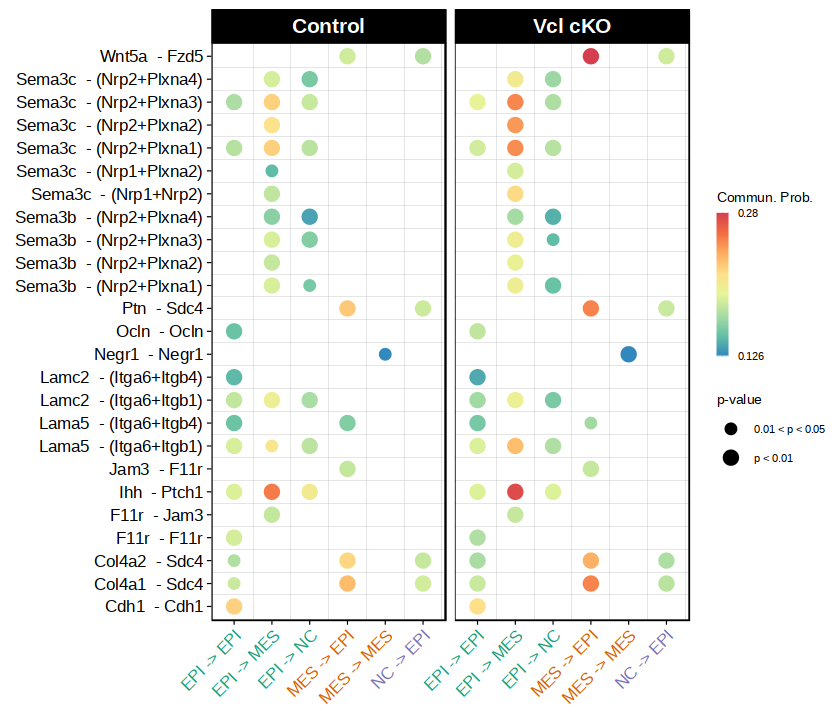

In [53]:
source("./plot.cellchat.gain.loss.R")
plot.data <- getdata(cellchat, comparison = c(1:2))

final.plot.data <- data.frame()

for(lr in unique(plot.data$interaction_name_2)){
    temp <- subset(plot.data, interaction_name_2 == lr)
    for(dire in unique(temp$group.names)){ 
        temp2 <- subset(temp, group.names == dire)
        if(length(unique(temp2$dataset)) == 2){ 
            final.plot.data <- rbind(final.plot.data, temp2)
        }
    }
}


final.plot.data$group.names	<- as.character(final.plot.data$group.names)
p <- Plot.Interac.gain.loss(final.plot.data = final.plot.data, size_n = 1)
options(repr.plot.width = 7, repr.plot.height = 6)
p

library(openxlsx)
wb <- createWorkbook()
addWorksheet(wb = wb, sheetName = "common interactions")
writeData(wb = wb, sheet = "common interactions", x = final.plot.data)

saveWorkbook(wb = wb, file = "./0_figure/Table_S3_common_interactions.xlsx", overwrite = T)

In [4]:
library(pheatmap)
final.plot.data <- subset(final.plot.data, dataset == "Vcl cKO")
summ <- table(final.plot.data$source, final.plot.data$target)
options(repr.plot.width = 6, repr.plot.height = 5)
p <- pheatmap(summ,
         cluster_rows = FALSE,
         main = paste0(length(unique(final.plot.data$interaction_name_2)), "/", length(unique(plot.data$interaction_name_2))),
         cluster_cols = FALSE,          
         fontsize = 16,   
         angle_col = "45",
         color = colorRampPalette(c("white", "#0080ff"))(50),  #
         display_numbers = TRUE,        
         number_color = "black",           
         border_color = "black"
);p

options(repr.plot.width = 4, repr.plot.height = 4)

a <- table(final.plot.data$pathway_name) %>% as.data.frame()
a <- a %>% arrange(Freq)
a$Var1 <- factor(a$Var1, levels = a$Var1)
ggplot(a, aes(y = Var1, x = Freq)) + geom_bar(stat = "identity") & xlab("number") & ylab("overlapped Signallings")

p

### 6. pie chart

In [4]:
obj <- readRDS("obj.target.region.rds")
# head(obj@meta.data)

In [51]:
plot.spatial.pie <- function(data = plot.data, image_path = image_path, sample = sample, pie_scale = 0.8, columns){
    spatial_coord <- data.frame(obj@images[[sample]]@coordinates) %>%
            tibble::rownames_to_column("barcodeID") %>% dplyr::mutate(imagerow_scaled = imagerow *
            obj@images[[sample]]@scale.factors$lowres, imagecol_scaled = imagecol *
            obj@images[[sample]]@scale.factors$lowres) %>% dplyr::inner_join(data %>%
            tibble::rownames_to_column("barcodeID"), by = "barcodeID")
     
    
    img <- png::readPNG(image_path)
     
    img_grob <- grid::rasterGrob(img, interpolate = FALSE, width = grid::unit(1,
            "npc"), height = grid::unit(1, "npc"))
     
    ####百分比饼图
    p1 <- scatterpie_pie <- ggplot2::ggplot() + 
        ggplot2::annotation_custom(grob = img_grob,
        xmin = 0, xmax = ncol(img), ymin = 0, ymax = -nrow(img)) +
        # scatterpie::geom_scatterpie(data = spatial_coord, ggplot2::aes(x = imagecol_scaled,y = imagerow_scaled), cols = c("LI", "SI", "ST"), color = NA,alpha = 1, pie_scale = pie_scale) +
        scatterpie::geom_scatterpie(data = spatial_coord, ggplot2::aes(x = imagecol_scaled,y = imagerow_scaled), cols = columns, color = NA, alpha = 1, pie_scale = pie_scale) +
        ggplot2::scale_y_reverse() + ggplot2::ylim(nrow(img),
        0) + ggplot2::xlim(0, ncol(img)) + cowplot::theme_half_open(11,
        rel_small = 1) + ggplot2::theme_void() + ggplot2::coord_fixed(ratio = 1,
         xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") & 
    # scale_fill_manual(values = c("LI" = "#fa58d0", "SI" = "#3ADF00", "ST" = "#6666FF")) 
    # &
        scale_fill_manual(values = c("MES" = "#FFE4B5", "EPI" = "#E41A1C", "NC" = "#4DAF4A"))
    
     
    return(p1)
}

In [240]:
obj@meta.data$NC <- obj@meta.data$"Neural crest cells"
propo <- obj@meta.data[,c("x", "y", "MES", "EPI", "NC", "orig.ident")]
# propo <- obj.final@meta.data[,c("x", "y", "MES", "NC", "EPI", "orig.ident")]

sample = "A1"
image_path <- "./EVSE220525-VclCN-A1-1_report/outs/spatial/tissue_lowres_image.png"
plot.data <- subset(propo, propo$orig.ident == sample)

p1 <- plot.spatial.pie(data = plot.data, image_path = image_path, sample = sample, pie_scale = 1.7, columns = c("MES", "EPI", "NC"))


sample = "D1"
image_path <- "./EVSE220525-VclMT-D1-1_report/outs/spatial/tissue_lowres_image.png"
plot.data <- subset(propo, propo$orig.ident == sample)
p2 <- plot.spatial.pie(data = plot.data, image_path = image_path, sample = sample, pie_scale = 2.1, columns = c("MES", "EPI", "NC"))

options(repr.plot.width = 10, repr.plot.height = 5)

pdf("./spatial.region.final.proportion.pdf", width = 10, height = 5)
p1 + p2
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


png 
  2